## Read and Explore data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
train_data = pd.read_csv('./data/train.csv')
train_data.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0,0,0,0,0,0


In [2]:
# Separate the type variable into different columns
def create_new_columns(column):
    unique_col_values = np.unique(column)
    new_values = [[1 if a==True else 0 for a in column == u] for u in unique_col_values]
    col_names = [f'Type_{u}' for u in unique_col_values]
    new_df = pd.DataFrame(dict(zip(col_names, new_values)))
    return new_df  # Modify this as needed

# Apply the function to create new columns
df = train_data.join(create_new_columns(train_data.loc[:,'Type']))
df.drop(['Type','id', 'Product ID'],axis=1,inplace=True)
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_H,Type_L,Type_M
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,0,1,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0,0,1
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,0,1,0
3,301.0,310.9,1524,44.3,197,0,0,0,0,0,0,0,1,0
4,298.0,309.0,1641,35.4,34,0,0,0,0,0,0,0,0,1


#### Explore distribution of dummy variables

In [4]:
# List binary variable names
var_names = ['TWF','HDF','PWF','OSF','RNF', 'Machine failure']
outcome_name = 'Machine failure'

# Choose if plot plot and print values
plot = False
print_values = True

if plot:
    # Create a figure and axis
    fig, axes = plt.subplots(3,2)
    for ax,var_name in zip(axes.flatten(), var_names):
        var_values = np.unique(train_data[var_name])
        dist_arr = [train_data[train_data[var_name] == var_value].shape[0]/train_data.shape[0] for var_value in var_values]
        cmap = get_cmap('RdYlGn', len(dist_arr))
        # Plot a bar chart with automatically selected colors
        ax.set(xticks = var_values)
        ax.set_title(f'{var_name} distribution')
        ax.bar(var_values, height = dist_arr, width = 0.3, color=[cmap(i) for i in range(len(dist_arr))])

if print_values:
    for var_name in var_names:
        var_values = np.unique(train_data[var_name])
        dist_arr = [train_data[train_data[var_name] == var_value].shape[0]/train_data.shape[0] for var_value in var_values]
        print({var_name:dict(zip(var_values,dist_arr))})

{'TWF': {0: 0.9984460781798591, 1: 0.0015539218201408792}}
{'HDF': {0: 0.9948398067859473, 1: 0.005160193214052731}}
{'PWF': {0: 0.9976031488906317, 1: 0.002396851109368243}}
{'OSF': {0: 0.9960418972505846, 1: 0.003958102749415447}}
{'RNF': {0: 0.9977424154688519, 1: 0.0022575845311480695}}
{'Machine failure': {0: 0.9842555468412141, 1: 0.01574445315878589}}


#### Look at feature distribution for the continuous variables

The noticeable differnce in the distribution of some continuous variables is a good indication that decision trees may achieve good performance in this binary classification problem

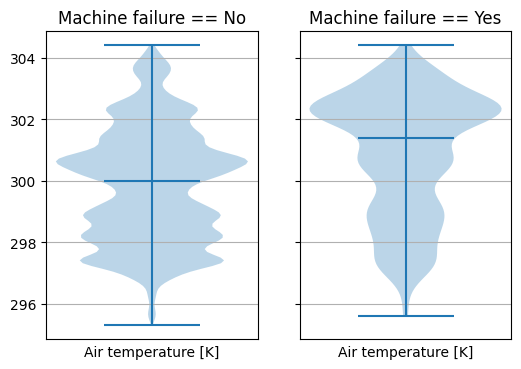

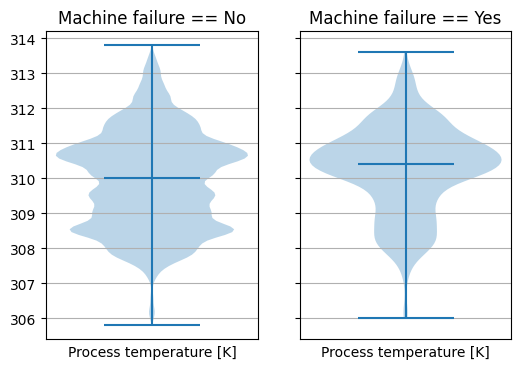

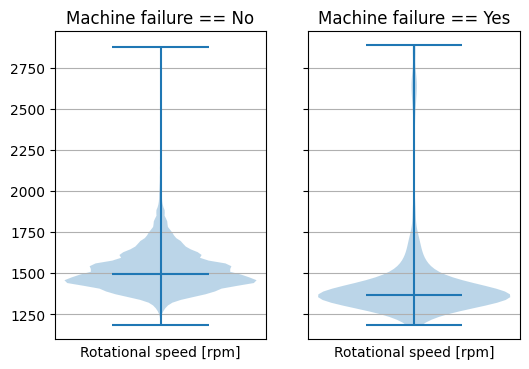

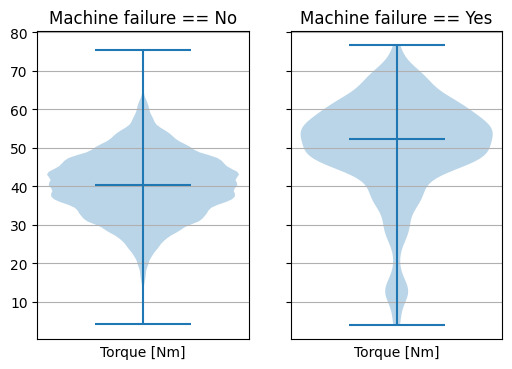

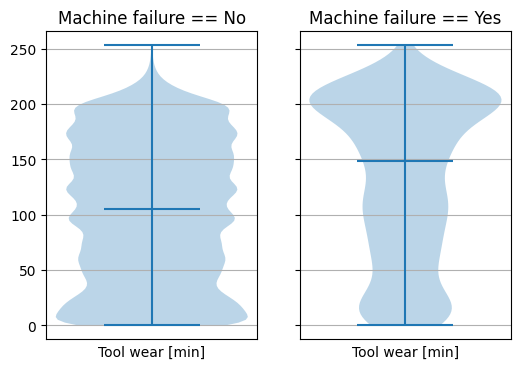

In [24]:
# Select only continuous variables
mf_no = df[df['Machine failure'] == 0].iloc[:,:5]
mf_yes = df[df['Machine failure'] == 1].iloc[:,:5]

# Plot violin plot for each variable according to machine failure
for col in mf_no.columns:
    fig, axs = plt.subplots(1,2,figsize=(6,4), sharey=True)
    axs[0].violinplot(mf_no[col], showmedians = True)
    axs[0].set_title('Machine failure == No')
    axs[1].violinplot(mf_yes[col], showmedians = True)
    axs[1].set_title('Machine failure == Yes')
    for ax in axs:
        ax.yaxis.grid(True)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        ax.set_xlabel(col)
    plt.show()

#### Perform PCA and plot result to have a look a two dimensional plot of class distribution

The plot is produced to have an idea of the extent of overlapping of predictors beetween the outcome classes. Such overlapping is especially worth considering when oversampling techniques such as Syntethic Minority Oversampling Technique (SMOTE) are used. In fact, SMOTE produces a convex combination of features from two samples in the minority class that are found to be closed to each other in feature space. If features from the minority class consistently overlap with features in the majority one the effectiveness of the oversampling technique is affected. 

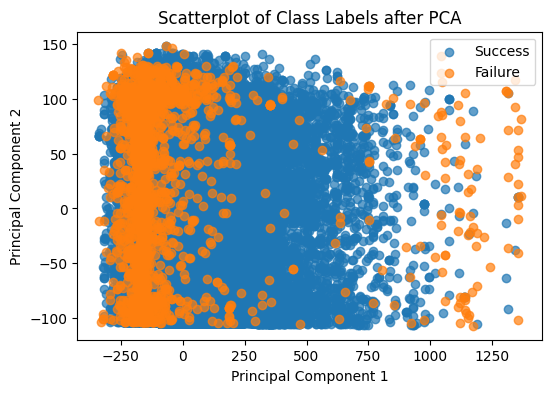

In [23]:
from sklearn.decomposition import PCA
# Perform PCA
X = df.drop('Machine failure', axis=1).values
y = df['Machine failure'].values
pca = PCA(2)
X_reduced = pca.fit_transform(X)

# Plot result
plt.figure(figsize=(6, 4))
plt.scatter(X_reduced[y == 0, 0], X_reduced[y == 0, 1], label='Success', alpha=0.7)
plt.scatter(X_reduced[y == 1, 0], X_reduced[y == 1, 1], label='Failure', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.title('Scatterplot of Class Labels after PCA')
plt.show()

#### Encode 'Type' column as dummy variable

In [27]:
# Explore some correlations of each predictor with repsonse variable
from sklearn.feature_selection import r_regression
from sklearn.preprocessing import OneHotEncoder

var_names = ['TWF','HDF','PWF','OSF','RNF']
outcome_name = 'Machine failure'

# OneHot Encode Type variable
enc = OneHotEncoder(sparse_output=False, categories='auto')
encoded_type = enc.fit_transform(train_data.loc[:,'Type'].values.reshape(-1,1))

# Save preprocessed data to csv
df.to_csv('./data/preprocessed.csv')